In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, det_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay

In [55]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Rescaling, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.utils import to_categorical

# Introduction

In [7]:
data = pd.read_csv('Dataset/emergency_classification.csv')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       2352 non-null   object
 1   emergency_or_not  2352 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 36.9+ KB


In [9]:
data.head()

image_names  emergency_or_not
0       0.jpg                 1
1       1.jpg                 1
2       2.jpg                 1
3       3.jpg                 1
4       4.jpg                 1

In [10]:
data['emergency_or_not'].value_counts()

emergency_or_not
0    1361
1     991
Name: count, dtype: int64

# Batch Loading

In [11]:
labels_list = list(data.sort_values(by='image_names')['emergency_or_not'].values)

In [12]:
len(labels_list)

2352

In [13]:
rng = np.random.default_rng()

In [14]:
for i in range(1):
    image_name = data['image_names'][rng.integers(len(labels_list))]
    img = plt.imread('Dataset/images/'+image_name)
    print(np.array(img).shape)

(224, 224, 3)


In [15]:
batch_size = 128

In [16]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(directory='Dataset/', 
                                            labels=labels_list, batch_size=batch_size, 
                                            image_size=(224, 224), shuffle=True,
                                            seed=42, validation_split=0.25, subset='both')

Found 2352 files belonging to 2 classes.
Using 1764 files for training.
Using 588 files for validation.


In [17]:
train_ds.class_names

[0, 1]

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

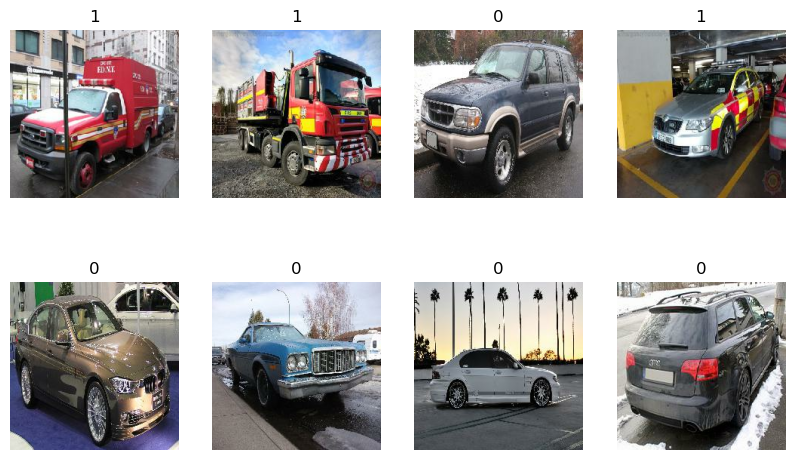

In [19]:
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(8):
        random_number = rng.integers(len(images))
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[random_number].numpy().astype("uint8"))
        plt.title(labels.numpy()[random_number])
        plt.axis("off")

In [20]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 224, 224, 3)
(128,)


In [23]:
for image_batch, labels_batch in train_ds.take(1):
    input_size = image_batch.shape.as_list()

In [39]:
y_test = tf.concat([y for x, y in test_ds], axis=0).numpy()

# Whole data Loading

In [17]:
X = []
for image_name in data['image_names']:
    img = plt.imread('Dataset/images/'+image_name)
    X.append(img)
X = np.array(X)

In [18]:
X.shape

(2352, 224, 224, 3)

In [19]:
y = data['emergency_or_not']

In [20]:
y.shape

(2352,)

In [21]:
rng = np.random.default_rng()

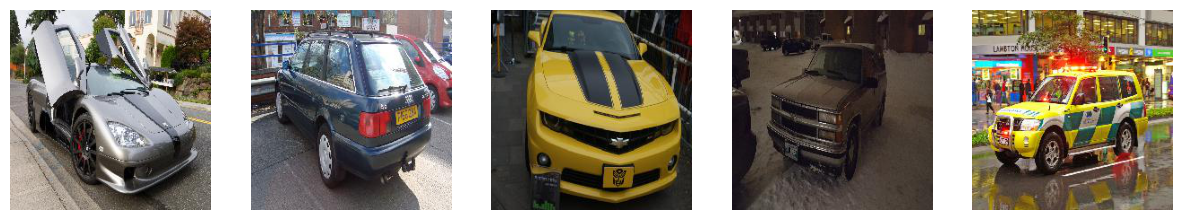

In [22]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(15,20))
for i in range(5):
    ax[i].imshow(X[rng.integers(X.shape[0])])
    ax[i].axis('off')

In [24]:
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])

In [25]:
X.shape

(2352, 150528)

In [26]:
X.min(), X.max()

(0, 255)

In [27]:
X = X / X.max()

In [17]:
X.min(), X.max()

(0.0, 1.0)

In [ ]:
import sys

In [ ]:
sys.getsizeof(X) / 2**30

6.8390351459383965

In [ ]:
sys.getsizeof(X_train) / 2**30

9.574424855411053

In [ ]:
%reset_selective -f '^X$'

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [29]:
X_train.shape, X_test.shape

((1646, 150528), (706, 150528))

actual class 0, predicted probability 0.17302176356315613


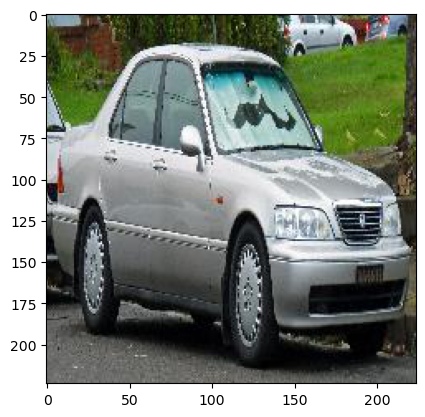

In [40]:
index = rng.integers(X_test.shape[0])
plt.imshow(np.reshape(X_test[index], (224,224,3)))
print(f'actual class {y_test.iloc[index]}, predicted probability {prediction[index][0]}')

# Basic Model

In [18]:
model = Sequential()
model.add(Rescaling(1./255))
model.add(Flatten())
model.add(Dense(units=100, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

In [19]:
list(train_ds.as_numpy_iterator())[0][0].shape

(128, 224, 224, 3)

In [21]:
model.build(input_shape=input_size)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (128, 224, 224, 3)        0         
                                                                 
 flatten (Flatten)           (128, 150528)             0         
                                                                 
 dense (Dense)               (128, 100)                15052900  
                                                                 
 dense_1 (Dense)             (128, 1)                  101       
                                                                 
Total params: 15053001 (57.42 MB)
Trainable params: 15053001 (57.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model.compile(optimizer=tf.keras.optimizers.SGD(), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [24]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=20, mode='max', baseline=0.5),
             ModelCheckpoint(filepath='vehicle_model.h5', monitor='val_binary_accuracy', mode='max', save_best_only=True)]

In [25]:
# history = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test))

In [26]:
history = model.fit(train_ds, epochs=20, callbacks=callbacks, validation_data=test_ds)

Epoch 1/20
14/14 [==============================] - 5s 300ms/step - loss: 0.7960 - binary_accuracy: 0.5850 - val_loss: 0.6372 - val_binary_accuracy: 0.6718
Epoch 2/20
14/14 [==============================] - 2s 150ms/step - loss: 0.6361 - binary_accuracy: 0.6440 - val_loss: 0.6189 - val_binary_accuracy: 0.6718
Epoch 3/20
14/14 [==============================] - 2s 165ms/step - loss: 0.6252 - binary_accuracy: 0.6587 - val_loss: 0.6088 - val_binary_accuracy: 0.6803
Epoch 4/20
14/14 [==============================] - 2s 171ms/step - loss: 0.6129 - binary_accuracy: 0.6627 - val_loss: 0.6019 - val_binary_accuracy: 0.6803
Epoch 5/20
14/14 [==============================] - 3s 205ms/step - loss: 0.6047 - binary_accuracy: 0.6763 - val_loss: 0.5952 - val_binary_accuracy: 0.6854
Epoch 6/20
14/14 [==============================] - 2s 147ms/step - loss: 0.5962 - binary_accuracy: 0.6842 - val_loss: 0.5908 - val_binary_accuracy: 0.6990
Epoch 7/20
14/14 [==============================] - 2s 146ms/ste

In [31]:
model = load_model('vehicle_model.h5')

In [32]:
prediction = model.predict(test_ds)

5/5 [==============================] - 0s 53ms/step


In [33]:
prediction_category = (prediction >= 0.5).astype(int)

In [35]:
print(classification_report(y_test, prediction_category))

              precision    recall  f1-score   support

           0       0.71      0.85      0.77       331
           1       0.74      0.54      0.63       257

    accuracy                           0.72       588
   macro avg       0.73      0.70      0.70       588
weighted avg       0.72      0.72      0.71       588



In [36]:
history_df = pd.DataFrame(history.history)

In [37]:
history_df.head()

loss  binary_accuracy  val_loss  val_binary_accuracy
0  0.795969         0.585034  0.637244             0.671769
1  0.636142         0.643991  0.618884             0.671769
2  0.625204         0.658730  0.608777             0.680272
3  0.612861         0.662698  0.601854             0.680272
4  0.604697         0.676304  0.595199             0.685374

In [38]:
pd.melt(history_df.reset_index(), id_vars='index')

index             variable     value
0       0                 loss  0.795969
1       1                 loss  0.636142
2       2                 loss  0.625204
3       3                 loss  0.612861
4       4                 loss  0.604697
..    ...                  ...       ...
75     15  val_binary_accuracy  0.714286
76     16  val_binary_accuracy  0.717687
77     17  val_binary_accuracy  0.719388
78     18  val_binary_accuracy  0.715986
79     19  val_binary_accuracy  0.715986

[80 rows x 3 columns]

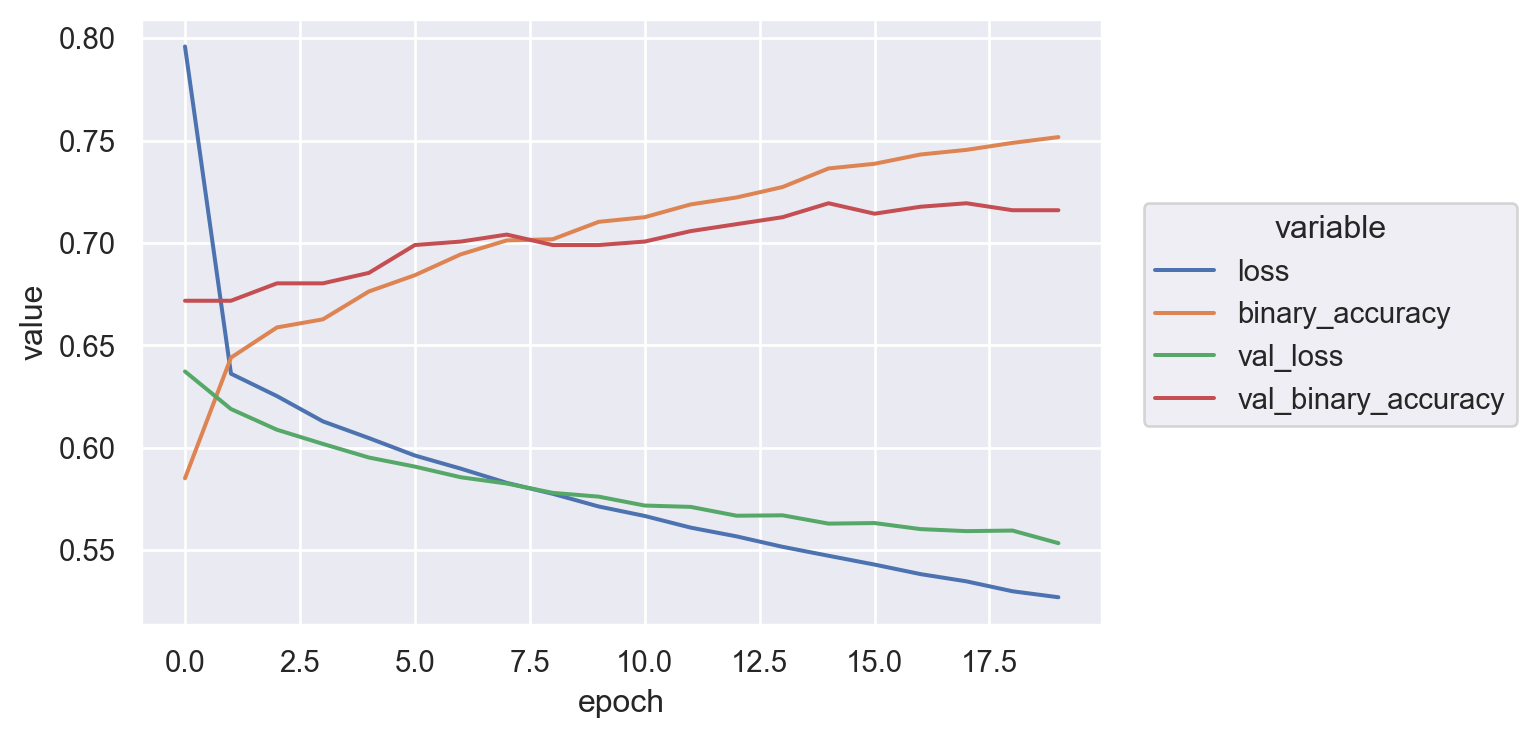

In [39]:
so.Plot(pd.melt(history_df.reset_index(), id_vars='index'), x='index', y='value', 
        color='variable').add(so.Line()).label(x='epoch').layout(size=(6,4))

Text(0.5, 0.01, 'epochs')

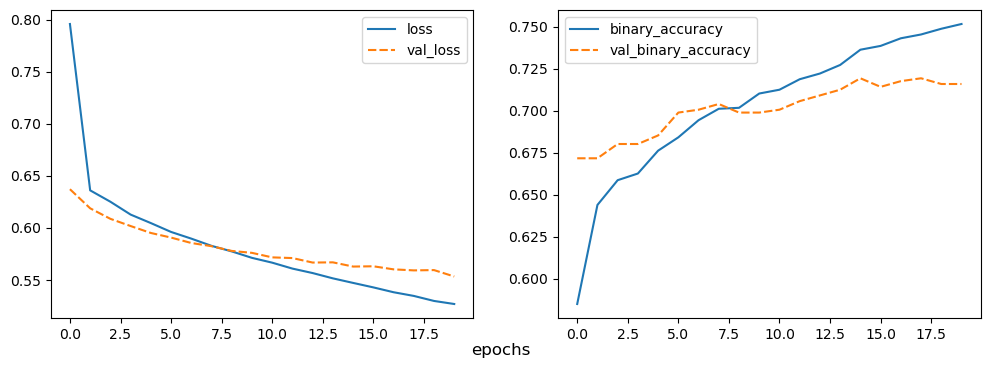

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

actual class 0, predicted probability 0.3647822141647339


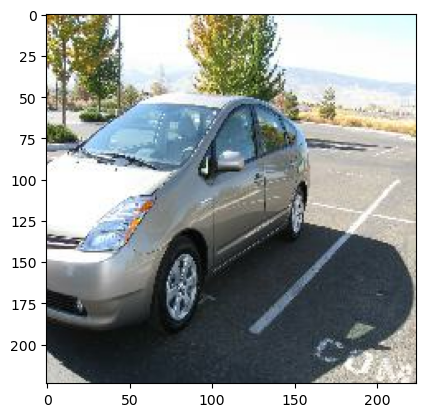

In [41]:
for images, labels in test_ds.take(1):
    random_n = rng.integers(len(images))
    plt.imshow(images[random_n].numpy().astype("uint8"))
    print(f'actual class {labels.numpy()[random_n]}, predicted probability {prediction[random_n][0]}')

# Hyper parameter tuning

## change activation function

In [24]:
model=Sequential()
model.add(Dense(units=100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=1, activation='sigmoid'))

In [107]:
# summary of the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 100)               15052900  
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15,053,001
Trainable params: 15,053,001
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer=tf.keras.optimizers.SGD(), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [109]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=50, mode='max', baseline=0.5),
             ModelCheckpoint(filepath='vehicle_model.h5', monitor='val_binary_accuracy', mode='max', save_best_only=True)]

In [110]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 7s 516ms/step - loss: 1.7418 - binary_accuracy: 0.5450 - val_loss: 0.6723 - val_binary_accuracy: 0.5609
Epoch 2/50
13/13 [==============================] - 3s 199ms/step - loss: 0.6556 - binary_accuracy: 0.6136 - val_loss: 0.6638 - val_binary_accuracy: 0.5652
Epoch 3/50
13/13 [==============================] - 3s 237ms/step - loss: 0.6437 - binary_accuracy: 0.6330 - val_loss: 0.6390 - val_binary_accuracy: 0.6686
Epoch 4/50
13/13 [==============================] - 3s 241ms/step - loss: 0.6363 - binary_accuracy: 0.6367 - val_loss: 0.6173 - val_binary_accuracy: 0.6756
Epoch 5/50
13/13 [==============================] - 3s 254ms/step - loss: 0.6144 - binary_accuracy: 0.6707 - val_loss: 0.6023 - val_binary_accuracy: 0.6841
Epoch 6/50
13/13 [==============================] - 2s 189ms/step - loss: 0.6148 - binary_accuracy: 0.6738 - val_loss: 0.6013 - val_binary_accuracy: 0.6912
Epoch 7/50
13/13 [==============================] - 2s 164ms/ste

In [111]:
model = load_model('vehicle_model.h5')

In [112]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 23ms/step


In [113]:
prediction_cat = (prediction >= 0.5).astype(int)

In [114]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       396
           1       0.71      0.61      0.65       310

    accuracy                           0.72       706
   macro avg       0.71      0.70      0.71       706
weighted avg       0.72      0.72      0.71       706



In [115]:
history_df = pd.DataFrame(history.history)

Text(0.5, 0.01, 'epochs')

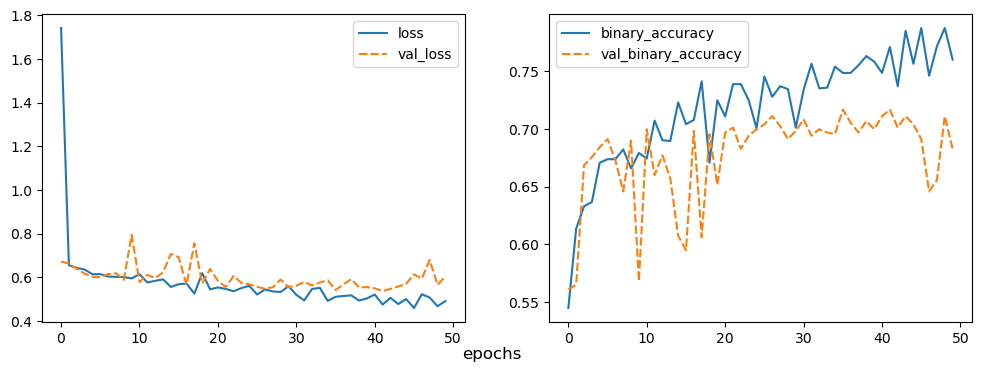

In [116]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

## change optimizer

In [117]:
model=Sequential()
model.add(Dense(units=100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=1, activation='sigmoid'))

In [118]:
# summary of the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 100)               15052900  
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15,053,001
Trainable params: 15,053,001
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [120]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=50, mode='max', baseline=0.5),
             ModelCheckpoint(filepath='vehicle_model.h5', monitor='val_binary_accuracy', mode='max', save_best_only=True)]

In [121]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 9s 655ms/step - loss: 27.5326 - binary_accuracy: 0.5322 - val_loss: 23.6749 - val_binary_accuracy: 0.5609
Epoch 2/50
13/13 [==============================] - 4s 319ms/step - loss: 8.3394 - binary_accuracy: 0.5680 - val_loss: 6.4137 - val_binary_accuracy: 0.5977
Epoch 3/50
13/13 [==============================] - 4s 308ms/step - loss: 5.3474 - binary_accuracy: 0.5911 - val_loss: 4.8044 - val_binary_accuracy: 0.6119
Epoch 4/50
13/13 [==============================] - 4s 321ms/step - loss: 2.9484 - binary_accuracy: 0.6561 - val_loss: 2.3589 - val_binary_accuracy: 0.6501
Epoch 5/50
13/13 [==============================] - 5s 367ms/step - loss: 1.3680 - binary_accuracy: 0.7424 - val_loss: 1.8861 - val_binary_accuracy: 0.6388
Epoch 6/50
13/13 [==============================] - 4s 342ms/step - loss: 0.9209 - binary_accuracy: 0.7369 - val_loss: 1.0332 - val_binary_accuracy: 0.6756
Epoch 7/50
13/13 [==============================] - 5s 422ms/s

In [122]:
model = load_model('vehicle_model.h5')

In [123]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 22ms/step


In [124]:
prediction_cat = (prediction >= 0.5).astype(int)

In [125]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       396
           1       0.77      0.60      0.68       310

    accuracy                           0.75       706
   macro avg       0.75      0.73      0.74       706
weighted avg       0.75      0.75      0.74       706



In [126]:
history_df = pd.DataFrame(history.history)

Text(0.5, 0.01, 'epochs')

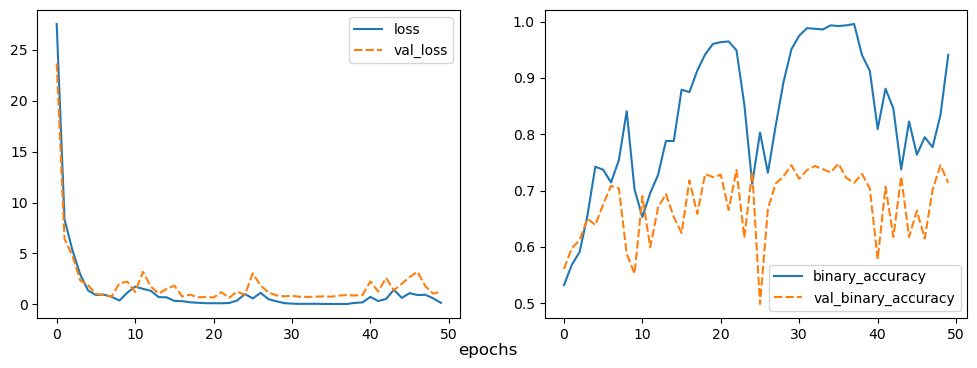

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

## increase hidden layers

In [128]:
model=Sequential()
model.add(Dense(units=100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [129]:
# summary of the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 100)               15052900  
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dense_19 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15,063,101
Trainable params: 15,063,101
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [131]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=50, mode='max', baseline=0.5),
             ModelCheckpoint(filepath='vehicle_model.h5', monitor='val_binary_accuracy', mode='max', save_best_only=True)]

In [132]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 9s 624ms/step - loss: 9.7283 - binary_accuracy: 0.5243 - val_loss: 3.4952 - val_binary_accuracy: 0.6048
Epoch 2/50
13/13 [==============================] - 4s 334ms/step - loss: 2.3564 - binary_accuracy: 0.5990 - val_loss: 1.3966 - val_binary_accuracy: 0.6161
Epoch 3/50
13/13 [==============================] - 4s 292ms/step - loss: 1.3955 - binary_accuracy: 0.6361 - val_loss: 1.7865 - val_binary_accuracy: 0.5482
Epoch 4/50
13/13 [==============================] - 4s 333ms/step - loss: 0.9197 - binary_accuracy: 0.6974 - val_loss: 0.9019 - val_binary_accuracy: 0.6572
Epoch 5/50
13/13 [==============================] - 5s 356ms/step - loss: 0.6697 - binary_accuracy: 0.7242 - val_loss: 0.7301 - val_binary_accuracy: 0.6771
Epoch 6/50
13/13 [==============================] - 7s 533ms/step - loss: 0.6015 - binary_accuracy: 0.7473 - val_loss: 0.5582 - val_binary_accuracy: 0.7238
Epoch 7/50
13/13 [==============================] - 4s 307ms/ste

In [133]:
model = load_model('vehicle_model.h5')

In [134]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 24ms/step


In [135]:
prediction_cat = (prediction >= 0.5).astype(int)

In [136]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80       396
           1       0.78      0.60      0.68       310

    accuracy                           0.75       706
   macro avg       0.76      0.73      0.74       706
weighted avg       0.75      0.75      0.74       706



In [137]:
history_df = pd.DataFrame(history.history)

Text(0.5, 0.01, 'epochs')

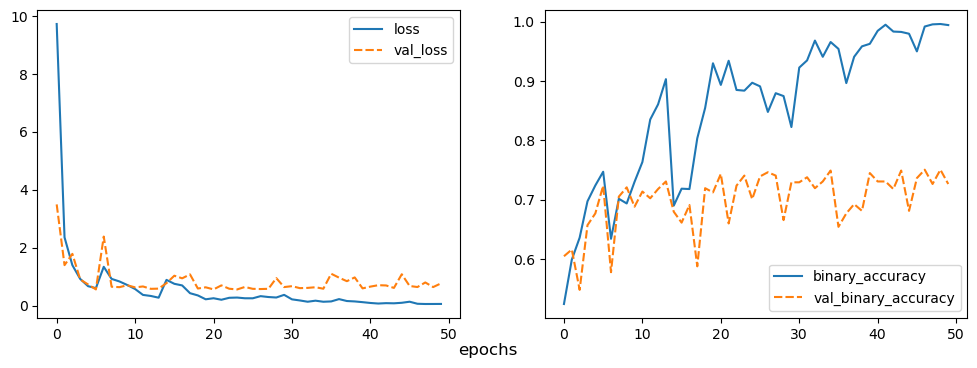

In [138]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

## change hidden neurons

In [150]:
model=Sequential()
model.add(Dense(units=25, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [151]:
# summary of the model
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 25)                3763225   
                                                                 
 dense_24 (Dense)            (None, 25)                650       
                                                                 
 dense_25 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3,763,901
Trainable params: 3,763,901
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [153]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=50, mode='max', baseline=0.5),
             ModelCheckpoint(filepath='vehicle_model.h5', monitor='val_binary_accuracy', mode='max', save_best_only=True)]

In [154]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 7s 498ms/step - loss: 1.6905 - binary_accuracy: 0.5541 - val_loss: 0.6369 - val_binary_accuracy: 0.6501
Epoch 2/50
13/13 [==============================] - 2s 129ms/step - loss: 0.7342 - binary_accuracy: 0.6409 - val_loss: 0.5948 - val_binary_accuracy: 0.6827
Epoch 3/50
13/13 [==============================] - 1s 114ms/step - loss: 0.5474 - binary_accuracy: 0.7363 - val_loss: 0.6087 - val_binary_accuracy: 0.6870
Epoch 4/50
13/13 [==============================] - 2s 122ms/step - loss: 0.5618 - binary_accuracy: 0.7375 - val_loss: 0.9917 - val_binary_accuracy: 0.5751
Epoch 5/50
13/13 [==============================] - 2s 129ms/step - loss: 0.5948 - binary_accuracy: 0.7035 - val_loss: 0.5610 - val_binary_accuracy: 0.7082
Epoch 6/50
13/13 [==============================] - 1s 117ms/step - loss: 0.4868 - binary_accuracy: 0.7776 - val_loss: 0.5405 - val_binary_accuracy: 0.7139
Epoch 7/50
13/13 [==============================] - 1s 112ms/ste

In [155]:
model = load_model('vehicle_model.h5')

In [156]:
prediction = model.predict(X_test)

23/23 [==============================] - 0s 12ms/step


In [157]:
prediction_cat = (prediction >= 0.5).astype(int)

In [158]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.82      0.72      0.76       396
           1       0.69      0.80      0.74       310

    accuracy                           0.75       706
   macro avg       0.75      0.76      0.75       706
weighted avg       0.76      0.75      0.75       706



In [159]:
history_df = pd.DataFrame(history.history)

Text(0.5, 0.01, 'epochs')

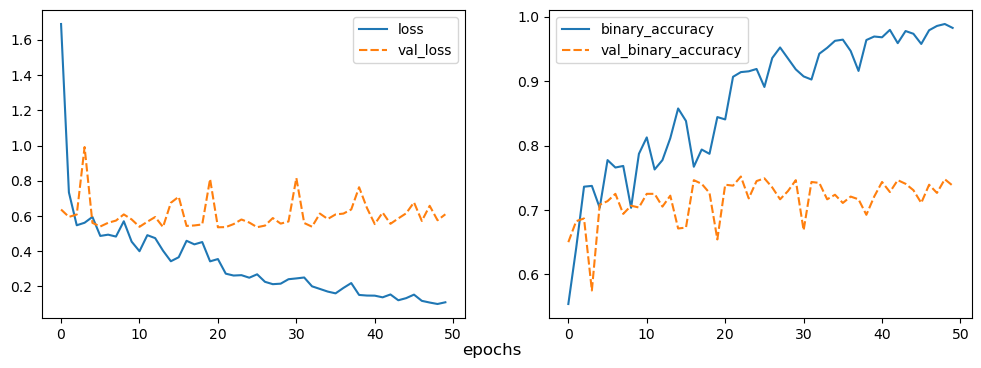

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

# Advanced model

In [42]:
model = Sequential()
model.add(Rescaling(1./255))
model.add(Flatten())
model.add(Dense(units=25, activation='relu', kernel_initializer=HeNormal()))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())
model.add(Dense(units=25, activation='relu', kernel_initializer=HeNormal()))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())
model.add(Dense(units=25, activation='relu', kernel_initializer=HeNormal()))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())
model.add(Dense(units=1, activation='sigmoid'))

In [43]:
model.build(input_shape=input_size)

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (128, 224, 224, 3)        0         
                                                                 
 flatten_1 (Flatten)         (128, 150528)             0         
                                                                 
 dense_2 (Dense)             (128, 25)                 3763225   
                                                                 
 dropout (Dropout)           (128, 25)                 0         
                                                                 
 batch_normalization (BatchN  (128, 25)                100       
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (128, 25)                 650       
                                                      

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [46]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=30, verbose=1, 
                           mode='max', baseline=0.5, restore_best_weights=True, start_from_epoch=10),
             ModelCheckpoint(filepath='vehicle_model.h5', monitor='val_binary_accuracy', verbose=0,
                             mode='max', save_best_only=True)]

In [47]:
history = model.fit(train_ds, epochs=50, callbacks=callbacks, validation_data=test_ds)

Epoch 1/50
14/14 [==============================] - 3s 134ms/step - loss: 0.8487 - binary_accuracy: 0.5153 - val_loss: 1.5679 - val_binary_accuracy: 0.5034
Epoch 2/50
14/14 [==============================] - 2s 152ms/step - loss: 0.7865 - binary_accuracy: 0.5601 - val_loss: 0.9300 - val_binary_accuracy: 0.5119
Epoch 3/50
14/14 [==============================] - 2s 137ms/step - loss: 0.7606 - binary_accuracy: 0.5652 - val_loss: 0.7605 - val_binary_accuracy: 0.5612
Epoch 4/50
14/14 [==============================] - 2s 117ms/step - loss: 0.7497 - binary_accuracy: 0.5601 - val_loss: 0.7337 - val_binary_accuracy: 0.5578
Epoch 5/50
14/14 [==============================] - 2s 130ms/step - loss: 0.7368 - binary_accuracy: 0.5748 - val_loss: 0.6929 - val_binary_accuracy: 0.5697
Epoch 6/50
14/14 [==============================] - 2s 130ms/step - loss: 0.7158 - binary_accuracy: 0.5697 - val_loss: 0.6731 - val_binary_accuracy: 0.5969
Epoch 7/50
14/14 [==============================] - 2s 132ms/ste

In [48]:
model = load_model('vehicle_model.h5')

In [49]:
prediction = model.predict(test_ds)

5/5 [==============================] - 0s 35ms/step


In [50]:
prediction_cat = (prediction >= 0.5).astype(int)

In [51]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       331
           1       0.75      0.64      0.69       257

    accuracy                           0.75       588
   macro avg       0.75      0.73      0.74       588
weighted avg       0.75      0.75      0.74       588



In [52]:
history_df = pd.DataFrame(history.history)

In [53]:
history_df.head()

loss  binary_accuracy  val_loss  val_binary_accuracy
0  0.848747         0.515306  1.567851             0.503401
1  0.786523         0.560091  0.929987             0.511905
2  0.760634         0.565193  0.760515             0.561224
3  0.749667         0.560091  0.733703             0.557823
4  0.736778         0.574830  0.692894             0.569728

Text(0.5, 0.01, 'epochs')

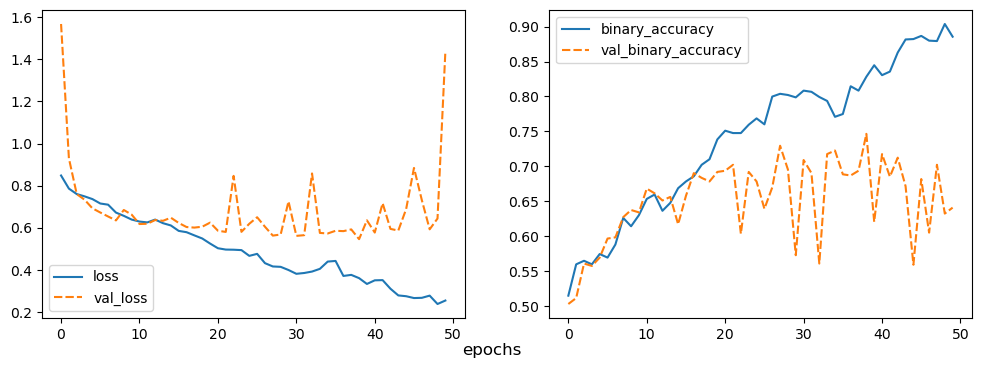

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

# CNN

In [21]:
model = Sequential()
model.add(Rescaling(1./255))
model.add(Conv2D(filters=25, kernel_size=(5,5), dilation_rate=(1,1), strides=(2,2), padding='valid'))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(4,4), padding='valid'))

model.add(Conv2D(filters=25, kernel_size=(5,5), dilation_rate=(1,1), strides=(2,2), padding='valid'))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(4,4), padding='valid'))

model.add(Flatten())
model.add(Dense(units=25, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(BatchNormalization())
model.add(Dense(units=25, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(BatchNormalization())
model.add(Dense(units=1, activation='sigmoid'))

In [24]:
model.build(input_shape=input_size)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (128, 224, 224, 3)        0         
                                                                 
 conv2d (Conv2D)             (128, 110, 110, 25)       1900      
                                                                 
 leaky_re_lu (LeakyReLU)     (128, 110, 110, 25)       0         
                                                                 
 max_pooling2d (MaxPooling2  (128, 27, 27, 25)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (128, 12, 12, 25)         15650     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (128, 12, 12, 25)         0         
                                                        

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [33]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=20, verbose=1, 
                           mode='max', baseline=0.5, restore_best_weights=True, start_from_epoch=5),
             ModelCheckpoint(filepath='vehicle_model_cnn.h5', monitor='val_binary_accuracy', verbose=0,
                             mode='max', save_best_only=True)]

In [34]:
history = model.fit(train_ds, epochs=20, callbacks=callbacks, validation_data=test_ds)

Epoch 1/20
14/14 [==============================] - 9s 634ms/step - loss: 0.0392 - binary_accuracy: 0.9887 - val_loss: 0.5093 - val_binary_accuracy: 0.8588
Epoch 2/20


C:\Users\dsanr\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 9s 677ms/step - loss: 0.0357 - binary_accuracy: 0.9909 - val_loss: 0.4804 - val_binary_accuracy: 0.8673
Epoch 3/20
14/14 [==============================] - 10s 712ms/step - loss: 0.0683 - binary_accuracy: 0.9807 - val_loss: 0.6097 - val_binary_accuracy: 0.8061
Epoch 4/20
14/14 [==============================] - 10s 740ms/step - loss: 0.0872 - binary_accuracy: 0.9671 - val_loss: 0.9597 - val_binary_accuracy: 0.7466
Epoch 5/20
14/14 [==============================] - 9s 675ms/step - loss: 0.0604 - binary_accuracy: 0.9790 - val_loss: 0.4563 - val_binary_accuracy: 0.8810
Epoch 6/20
14/14 [==============================] - 10s 709ms/step - loss: 0.0472 - binary_accuracy: 0.9841 - val_loss: 0.4278 - val_binary_accuracy: 0.8724
Epoch 7/20
14/14 [==============================] - 10s 700ms/step - loss: 0.0497 - binary_accuracy: 0.9841 - val_loss: 0.9714 - val_binary_accuracy: 0.7602
Epoch 8/20
14/14 [==============================] - 9s 641ms/step - los

In [35]:
model = load_model('vehicle_model_cnn.h5')

In [36]:
prediction = model.predict(test_ds)

5/5 [==============================] - 1s 172ms/step


In [37]:
prediction_cat = (prediction >= 0.5).astype(int)

In [40]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       331
           1       0.93      0.78      0.85       257

    accuracy                           0.88       588
   macro avg       0.89      0.87      0.88       588
weighted avg       0.89      0.88      0.88       588



In [71]:
history_df = pd.DataFrame(history.history)

In [72]:
history_df.head()

loss  binary_accuracy  val_loss  val_binary_accuracy
0  0.866946         0.514172  0.723882             0.562925
1  0.835462         0.530612  0.673006             0.562925
2  0.783285         0.531179  0.665474             0.566327
3  0.736233         0.568594  0.684070             0.559524
4  0.702307         0.574263  0.656862             0.571429

Text(0.5, 0.01, 'epochs')

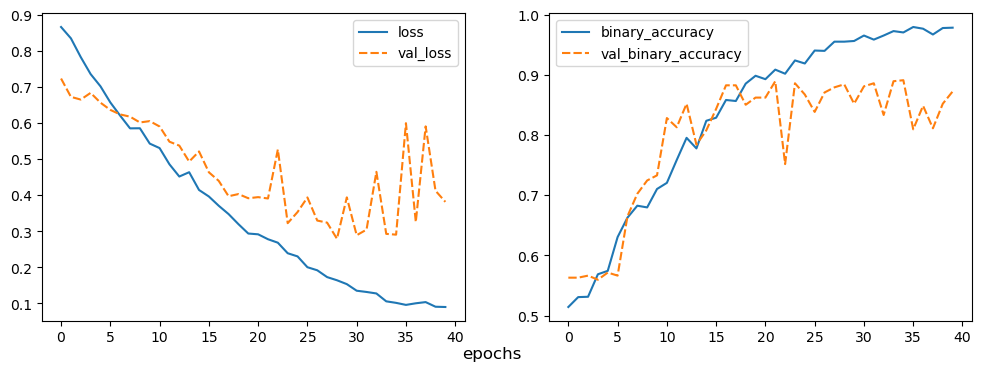

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

# Transfer Learning

In [234]:
base_model = inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=Input(shape=(224,224,3)))

In [56]:
base_model = EfficientNetV2B0(include_top=True, weights='imagenet')

29403144/29403144 [==============================] - 5s 0us/step


In [57]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          0         ['rescaling_3[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalizatio

In [58]:
len(base_model.layers)

273

In [59]:
base_model.layers[-10:]

In [60]:
for layer in base_model.layers:
    layer.trainable = False

In [61]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))

TypeError: in user code:

    File "C:\Users\dsanr\AppData\Local\Temp\ipykernel_11856\2281923410.py", line 1, in None  *
        lambda x, y: (x, tf.one_hot(y, depth=2))

    TypeError: Value passed to parameter 'indices' has DataType float32 not in list of allowed values: uint8, int8, int32, int64


In [62]:
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))

TypeError: in user code:

    File "C:\Users\dsanr\AppData\Local\Temp\ipykernel_11856\3378067709.py", line 1, in None  *
        lambda x, y: (x, tf.one_hot(y, depth=2))

    TypeError: Value passed to parameter 'indices' has DataType float32 not in list of allowed values: uint8, int8, int32, int64


In [63]:
dense = Dense(10, activation='relu')(base_model.layers[-2].output)
y = Dense(2, activation='softmax')(dense)

In [64]:
y = Dense(2, activation='softmax')(base_model.layers[-2].output)

In [65]:
model = Model(inputs=base_model.input, outputs=y)

In [66]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [67]:
callbacks = [EarlyStopping(monitor='val_categorical_accuracy', min_delta=.001, patience=10, verbose=1, 
                           mode='max', baseline=0.5, restore_best_weights=True, start_from_epoch=5),
             ModelCheckpoint(filepath='vehicle_model_tl.h5', monitor='val_categorical_accuracy', verbose=0,
                             mode='max', save_best_only=True)]

In [68]:
history = model.fit(train_ds, epochs=3, validation_data=test_ds)

Epoch 1/3
14/14 [==============================] - 71s 5s/step - loss: 0.4930 - categorical_accuracy: 0.7579 - val_loss: 0.2745 - val_categorical_accuracy: 0.9269
Epoch 2/3
14/14 [==============================] - 74s 5s/step - loss: 0.2592 - categorical_accuracy: 0.9087 - val_loss: 0.1721 - val_categorical_accuracy: 0.9456
Epoch 3/3
14/14 [==============================] - 82s 6s/step - loss: 0.1994 - categorical_accuracy: 0.9280 - val_loss: 0.1423 - val_categorical_accuracy: 0.9524


In [69]:
prediction = model.predict(test_ds)

5/5 [==============================] - 16s 3s/step


In [70]:
prediction_cat = (prediction >= 0.5).astype(int)

In [71]:
print(classification_report(y_test, prediction_cat[:, 1]))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       331
           1       0.96      0.93      0.94       257

    accuracy                           0.95       588
   macro avg       0.95      0.95      0.95       588
weighted avg       0.95      0.95      0.95       588



In [91]:
history_df = pd.DataFrame(history.history)

In [92]:
history_df.head()

loss  categorical_accuracy  val_loss  val_categorical_accuracy
0  0.497244              0.758503  0.284613                  0.904762
1  0.275686              0.901361  0.189969                  0.937075
2  0.217691              0.915533  0.158327                  0.945578
3  0.197521              0.928005  0.141887                  0.950680
4  0.181919              0.927438  0.133689                  0.962585

Text(0.5, 0.01, 'epochs')

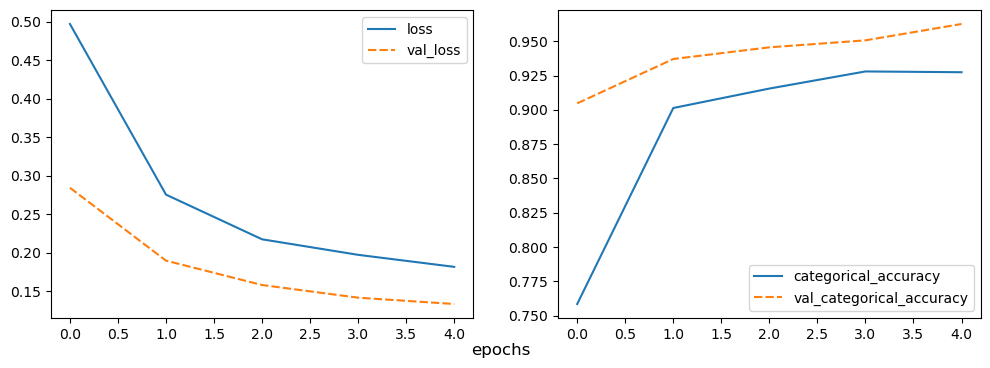

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['categorical_accuracy', 'val_categorical_accuracy']], ax=ax2)
fig.supxlabel('epochs')

# Visualizations

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 25)      1900      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 110, 110, 25)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 25)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 25)        15650     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12, 12, 25)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 25)         0         
 2D)                                                    

In [36]:
model.layers

In [37]:
model.layers[2].name

'max_pooling2d'

In [38]:
model.layers[1].get_config()

{'name': 'leaky_re_lu',
 'trainable': True,
 'dtype': 'float32',
 'alpha': 0.30000001192092896}

## filters

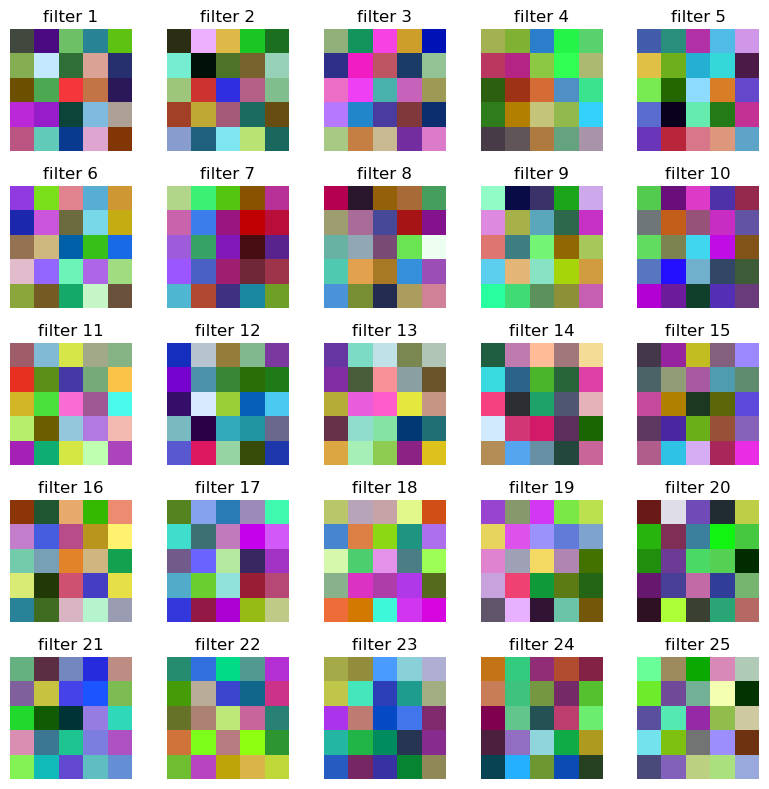

In [39]:
plt.figure(figsize=(8,8))
for i in range(25):
    layer_weights = model.get_layer(index=0).get_weights()[0][:,:,:,i]
    layer_weights -= layer_weights.min()
    layer_weights /= layer_weights.max()
    plt.subplot(5, 5, i+1)
    plt.imshow(layer_weights)
    plt.title('filter ' + str(i+1))
    plt.axis('off')
plt.tight_layout()

## intermediate layers

In [40]:
image = X_train[5]

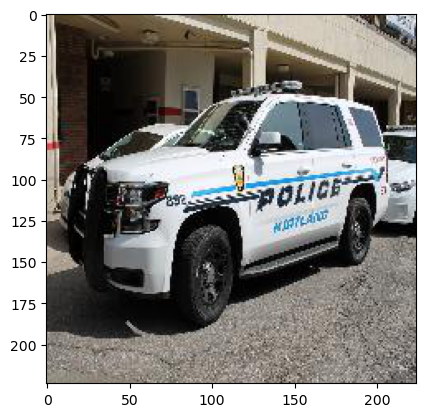

In [41]:
plt.imshow(X_train[5])

In [42]:
image.shape

(224, 224, 3)

In [43]:
image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

In [44]:
image.shape

(1, 224, 224, 3)

In [45]:
[i.name for i in model.layers]

['conv2d',
 'leaky_re_lu',
 'max_pooling2d',
 'conv2d_1',
 'leaky_re_lu_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'dropout',
 'batch_normalization',
 'dense_1',
 'dropout_1',
 'batch_normalization_1',
 'dense_2']

In [49]:
layer_names = [i.name for i in model.layers][:6]

In [50]:
outputs = []

In [51]:
for layer_name in layer_names:
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    outputs.append(intermediate_layer_model.predict(image))

1/1 [==============================] - 0s 46ms/step


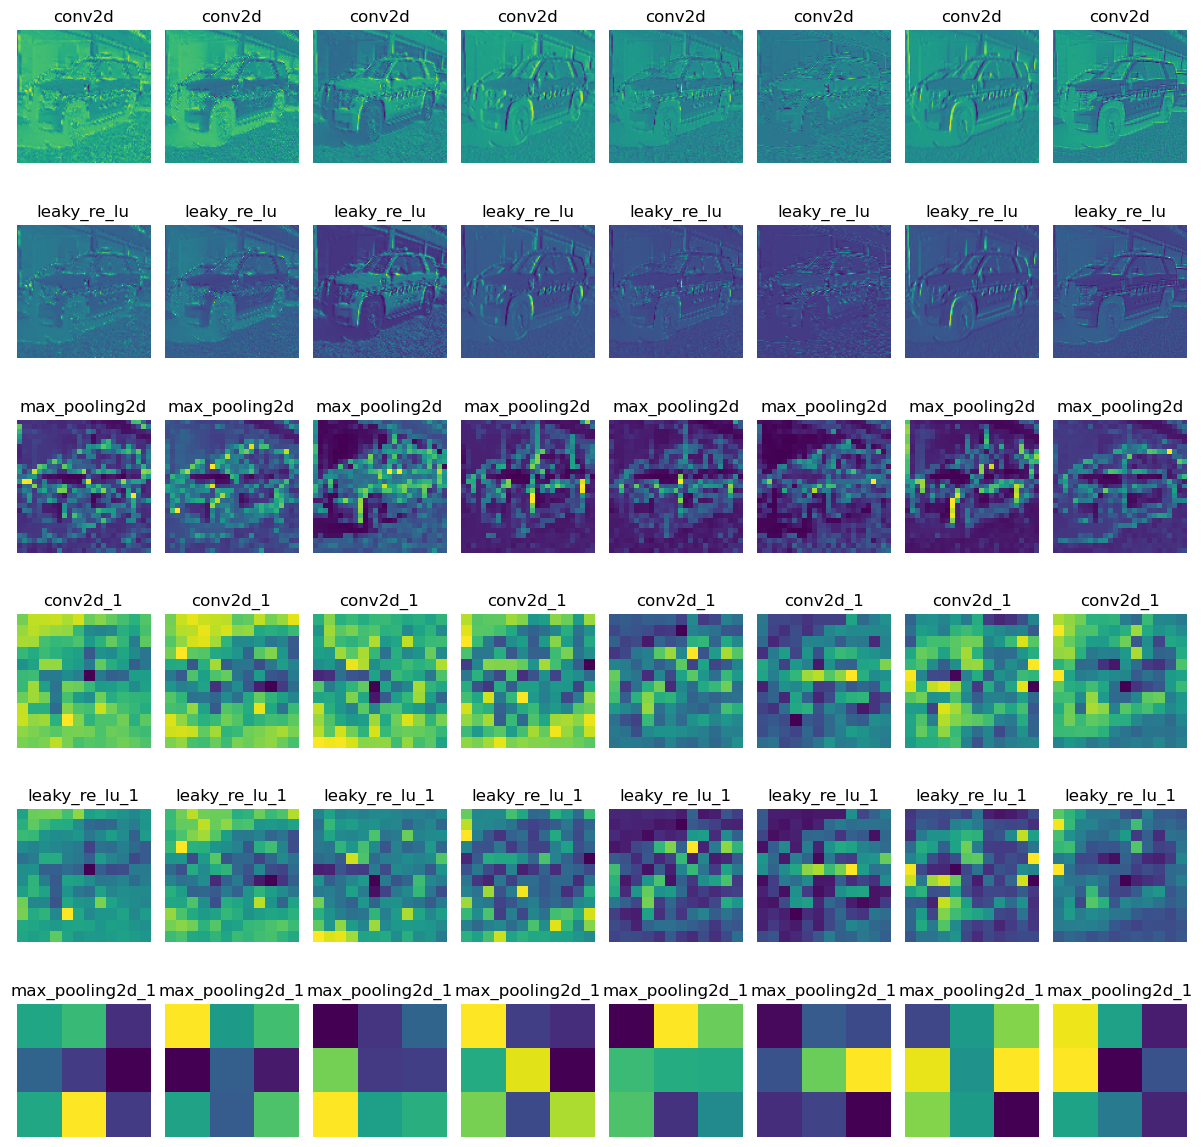

In [52]:
fig, axs = plt.subplots(6,8,figsize=(12,12))
for i in range(6):
    for z in range(8):
        axs[i][z].imshow(outputs[i][0,:,:,z])
        axs[i][z].set_title(layer_names[i])
        axs[i][z].axis('off')
plt.tight_layout()

## salience map

In [2]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear, ExtractIntermediateLayer
from tf_keras_vis.utils.scores import CategoricalScore, BinaryScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress

In [55]:
from matplotlib import cm

In [56]:
saliency = Saliency(model, model_modifier=ReplaceToLinear(), clone=True)

In [57]:
saliency_map = saliency(BinaryScore(1.0), image, smooth_samples=20, smooth_noise=0.2)

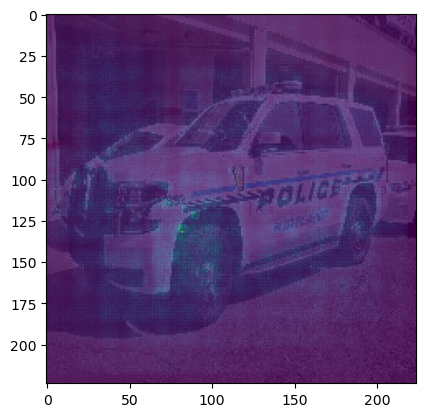

In [74]:
plt.imshow(X_train[5])
plt.imshow(saliency_map[0], alpha=0.8)

In [59]:
gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)

In [60]:
cam = gradcam(BinaryScore(1.0), image, penultimate_layer=-1)

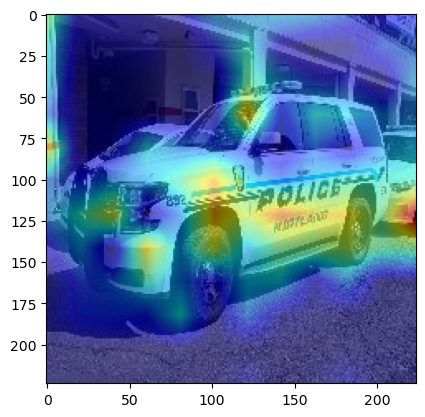

In [72]:
plt.imshow(X_train[5])
plt.imshow(np.uint8(cm.jet(cam[0])[..., :3] * 255), alpha=0.5)

In [63]:
gradcam_plusplus = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), clone=True)

In [64]:
cam_plusplus = gradcam_plusplus(BinaryScore(1.0), image, penultimate_layer=-1)

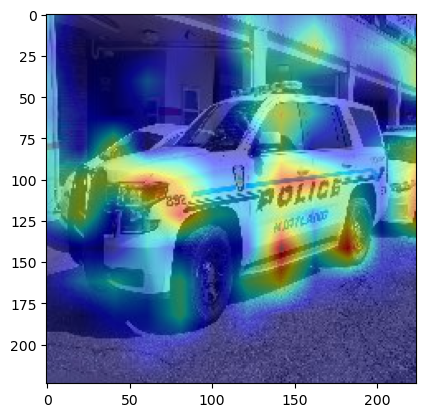

In [71]:
plt.imshow(X_train[5])
plt.imshow(np.uint8(cm.jet(cam_plusplus[0])[..., :3] * 255), alpha=0.5)

## activation maximization

In [76]:
model.layers[0].name

'conv2d'

In [77]:
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=model.layers[1].name)


In [78]:
activation_maximization = ActivationMaximization(model, 
                                            model_modifier=[extract_intermediate_layer, ReplaceToLinear()],
                                            clone=False)

In [79]:
activations = activation_maximization(CategoricalScore(0), callbacks=[Progress()])

200/200 [==============================] - 7s 37ms/step - Score: -7.9564 - TotalVariation2D: 4.5786 - Norm: 38.0285


In [80]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

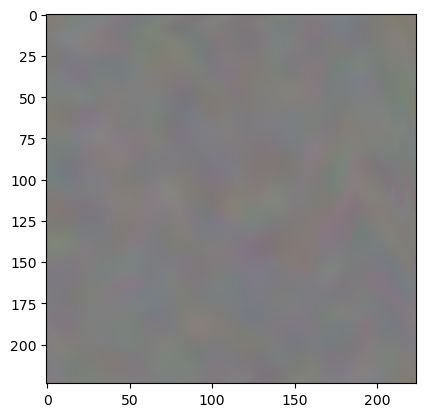

In [81]:
plt.imshow(activations[0].astype(np.uint8))

## occlusion map

In [82]:
def iter_occlusion(image, size=4):
    # taken from https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, ( \
    (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
    ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
             x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
             = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
             tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]


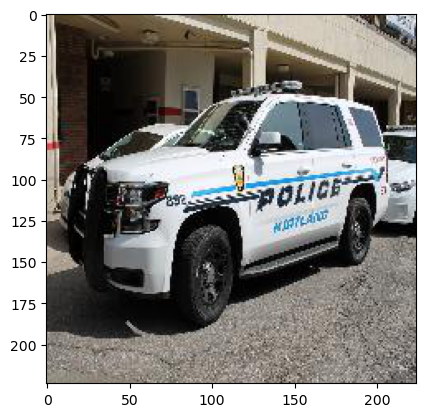

[None]

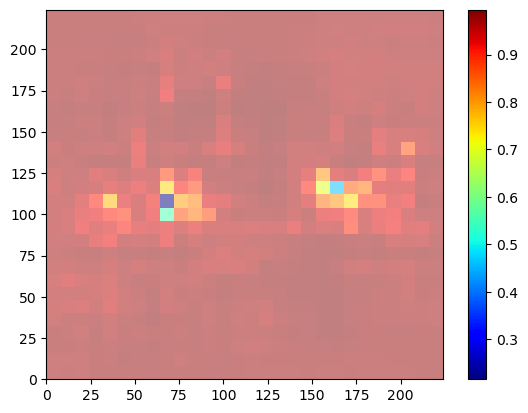

In [83]:

# take example image
image = X_train[5]
correct_class = np.argmax(y_train[5])

# define variables to use
img_size = image.shape[0]
occlusion_size = 8
heatmap = np.zeros((img_size, img_size), np.float32)
class_pixels = np.zeros((img_size, img_size), np.int16)

from collections import defaultdict
counters = defaultdict(int)

for n, (x, y, img_float) in enumerate(iter_occlusion(image, size=occlusion_size)):

    X = img_float.reshape(1, 224, 224, 3)
    out = model.predict(X, verbose=0)

    heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
    class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
    counters[np.argmax(out)] += 1

plt.imshow(image)

plt.show()

plt.pcolormesh(heatmap, cmap=plt.cm.jet, alpha=0.50)
plt.colorbar().solids.set(alpha=1)
